In [206]:
#all import

import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Gensim
import gensim
from gensim import corpora
from pprint import pprint
from gensim.models import CoherenceModel

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# When reading a csv again
from ast import literal_eval

# NTLK 
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


bible_cleaned_filename = 'bible-cleaned.csv'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nathanst/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/nathanst/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/nathanst/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# Import bible csv
bible_df = pd.read_csv('bible.csv')

In [3]:
# Stats descriptives sur le dataframe
bible_df.rename(columns={
    'b': 'book_id', 
    'c': 'chapter_id',
    'v': 'verse_id',
    't': 'text'
    }, inplace=True)

bible_df

id  book_id  chapter_id  verse_id  \
0       1001001        1           1         1   
1       1001002        1           1         2   
2       1001003        1           1         3   
3       1001004        1           1         4   
4       1001005        1           1         5   
...         ...      ...         ...       ...   
31098  66022017       66          22        17   
31099  66022018       66          22        18   
31100  66022019       66          22        19   
31101  66022020       66          22        20   
31102  66022021       66          22        21   

                                                    text  
0      In the beginning God created the heaven and th...  
1      And the earth was without form, and void; and ...  
2      And God said, Let there be light: and there wa...  
3      And God saw the light, that it was good: and G...  
4      And God called the light Day, and the darkness...  
...                                                  ...  
31098  And the Spirit and the bride say, Come. And le...  
31099  For I testify unto every man that heareth the ...  
31100  And if any man shall take away from the words ...  
31101  He which testifieth these things saith, Surely...  
31102  The grace of our Lord Jesus Christ be with you...  

[31103 rows x 5 columns]

In [4]:
# Now, clean !

# Use lambda to apply the function to each row of the DataFrame
def remove_all_punctuation(text):
   return re.sub(r'[^\w\s]', ' ', text)

def remove_partial_punctuation(text): # except .!?
   return re.sub(r'[^\w\s.!?]', ' ', text)

def carriage_return(text):
   return re.sub(r'\n', ' ', text)

def remove_double_space(text): # remove when more than 2 spaces
   return re.sub(r'[ ]{2,}', ' ', text)

def remove_empty_strings(text):
    return list(filter(None, text))

def remove_stopwords(text):
   text = tokenize(text)
   filtered_words = [word for word in text if word.lower() not in stopwords.words('english')]
   return filtered_words

def tokenize(text):
   return text.split(' ')

def join(text):
   return ' '.join(text)

def lemmatize(text):
    WNlemma = nltk.WordNetLemmatizer()
    lemmatized = []
    for token in text:
        lemmatized.append(WNlemma.lemmatize(token))
    return lemmatized

def remove_numbers(text):
    numbers = '0123456789'
    for number in numbers:
        text = text.replace(number, '')
    return text

def remove_short_words(word_list):
    return [word for word in word_list if len(word) > 1]

In [5]:
# As the processing is quite long, execute this only if the generated csv file does not exist. Otherwise, import it. 
if os.path.isfile(bible_cleaned_filename):
    bible_df = pd.read_csv('bible-cleaned.csv', index_col=0, converters={'cleaned': literal_eval})
else:
    #Text without stopwords
   bible_df['cleaned'] = bible_df['text'] \
      .apply(lambda x: remove_stopwords(x)) \
      .apply(lambda x: join(x)) \
      .apply(lambda x: carriage_return(x)) \
      .apply(lambda x: remove_double_space(x)) \
      .apply(lambda x: x.lower()) \
      .apply(lambda x: remove_all_punctuation(x)) \
      .apply(lambda x: remove_numbers(x)) \
      .apply(lambda x: tokenize(x)) \
      .apply(lambda x: remove_empty_strings(x)) \
      .apply(lambda x: lemmatize(x)) \
      .apply(lambda x: remove_short_words(x))
   
   # Export in csv so that it won't take long to reprocess anything
   bible_df.to_csv('bible-cleaned.csv')


# Statistiques du texte (avec visualisations)

In [6]:
# Add descriptive columns
bible_df['word_count'] = bible_df['cleaned'].apply(lambda x: len(' '.join(x).split()))
bible_df['unique_words'] = bible_df['cleaned'].apply(lambda x: len(set(x)))
bible_df['avg_word_length'] = bible_df['cleaned'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
bible_df['sentence_count'] = bible_df['text'].apply(lambda x: x.count('.') + x.count('!') + x.count('?'))

bible_df

id  book_id  chapter_id  verse_id  \
0       1001001        1           1         1   
1       1001002        1           1         2   
2       1001003        1           1         3   
3       1001004        1           1         4   
4       1001005        1           1         5   
...         ...      ...         ...       ...   
31098  66022017       66          22        17   
31099  66022018       66          22        18   
31100  66022019       66          22        19   
31101  66022020       66          22        20   
31102  66022021       66          22        21   

                                                    text  \
0      In the beginning God created the heaven and th...   
1      And the earth was without form, and void; and ...   
2      And God said, Let there be light: and there wa...   
3      And God saw the light, that it was good: and G...   
4      And God called the light Day, and the darkness...   
...                                                  ...   
31098  And the Spirit and the bride say, Come. And le...   
31099  For I testify unto every man that heareth the ...   
31100  And if any man shall take away from the words ...   
31101  He which testifieth these things saith, Surely...   
31102  The grace of our Lord Jesus Christ be with you...   

                                                 cleaned  word_count  \
0               [beginning, god, created, heaven, earth]           5   
1      [earth, without, form, void, darkness, upon, f...          14   
2                         [god, said, let, light, light]           5   
3      [god, saw, light, good, god, divided, light, d...           8   
4      [god, called, light, day, darkness, called, ni...          11   
...                                                  ...         ...   
31098  [spirit, bride, say, come, let, heareth, say, ...          18   
31099  [testify, unto, every, man, heareth, word, pro...          20   
31100  [man, shall, take, away, word, book, prophecy,...          19   
31101  [testifieth, thing, saith, surely, come, quick...          12   
31102            [grace, lord, jesus, christ, all, amen]           6   

       unique_words  avg_word_length  sentence_count  
0                 5         6.000000               1  
1                12         4.785714               2  
2                 4         4.000000               1  
3                 6         4.750000               1  
4                 9         5.272727               2  
...             ...              ...             ...  
31098            13         4.666667               4  
31099            14         4.700000               0  
31100            14         4.421053               1  
31101            11         5.000000               3  
31102             6         4.500000               2  

[31103 rows x 10 columns]

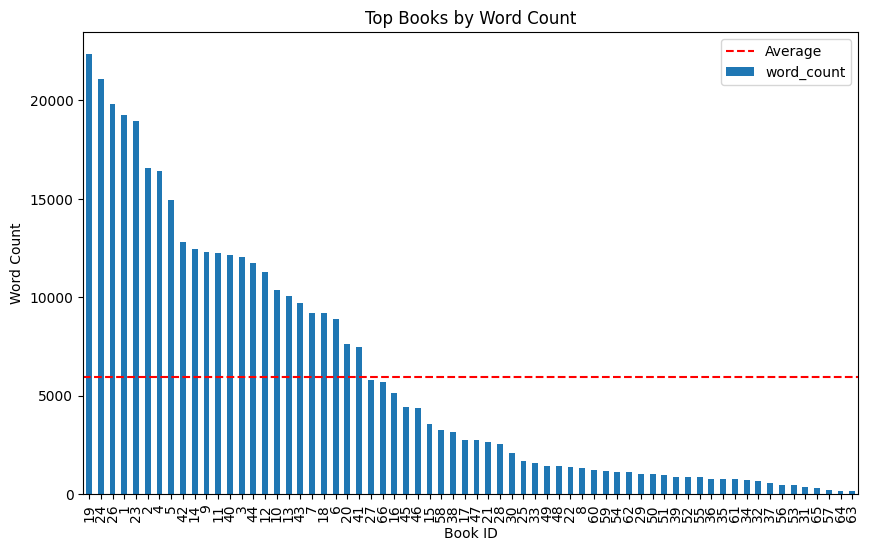

In [7]:
# Top des livres par nombre de mots (top 20) pour la lisibilité
top_books = bible_df.groupby('book_id')['word_count'].sum().nlargest(66)
average_word_count = top_books.mean()

top_books.plot(kind='bar', figsize=(10, 6))
plt.axhline(average_word_count, color='red', linestyle='--', label='Average')
plt.xlabel('Book ID')
plt.ylabel('Word Count')
plt.title('Top Books by Word Count')
plt.legend()
plt.show()

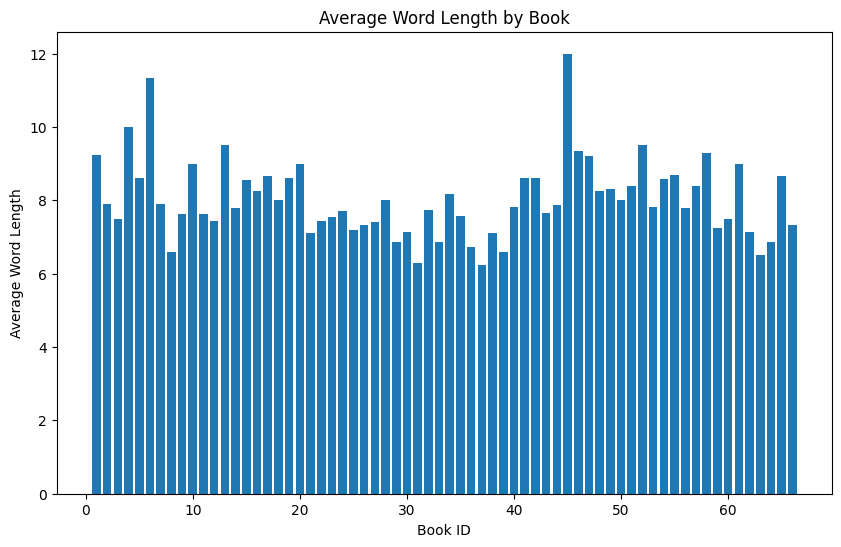

In [8]:
# Nombres de mots par livre de la bible 
plt.figure(figsize=(10, 6))
bible_df_sorted = bible_df.sort_values('avg_word_length', ascending=False)  # Sort in descending order
plt.bar(bible_df_sorted['book_id'], bible_df_sorted['avg_word_length'])
plt.xlabel('Book ID')
plt.ylabel('Average Word Length')
plt.title('Average Word Length by Book')
plt.show()

## 2. Nettoyage des données

Définition de plusieurs fonctions de nettoyage des données, et application de ces dernières sur différentes colonnes du dataframe, correspondant à un niveau de nettoyage différent qui sera utile pour les prochaines étapes. 

In [9]:
# Test cleaning efficiency printing the first row
# cela permet de comparer les différentes étapes de nettoyage
print('Cleaned text: \n' + str(bible_df['text'][0]))
print('Cleaned text: \n' + str(bible_df['cleaned'][0]))


Cleaned text: 
In the beginning God created the heaven and the earth.
Cleaned text: 
['beginning', 'god', 'created', 'heaven', 'earth']


## 3.Analyse des données

### Analyse des mots les plus fréquents

In [10]:
# Concatenate all the cleaned text into a single string
all_text = ' '.join(bible_df['cleaned'].sum())

# Count the frequency of each word in the text
word_counts = Counter(all_text.split())

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Print the top words
for word, count in top_words:
    print(f'{word}: {count}')

shall: 9838
unto: 8997
lord: 8006
thou: 5474
god: 4716
thy: 4600
said: 3999
ye: 3982
thee: 3827
him: 3493


In [11]:
# Number of verse in the bible
print("Number of verse in the bible : ", len(bible_df))

Number of verse in the bible :  31103


In [12]:
unique_words = len(bible_df['text'].explode().unique())
print("Number of unique words in the Bible:", unique_words)

Number of unique words in the Bible: 30834


In [13]:
# Count the number of times "Jesus" appears in the Bible
jesus_count = bible_df['cleaned'].explode().str.count('jesus').sum()

# Print the result
print("Number of times 'Jesus' appears in the Bible:", int(jesus_count))

Number of times 'Jesus' appears in the Bible: 984


In [14]:
god_count = bible_df['cleaned'].explode().str.count('god').sum()
print("Number of times 'God' appears in the Bible:", int(god_count))

Number of times 'God' appears in the Bible: 4787


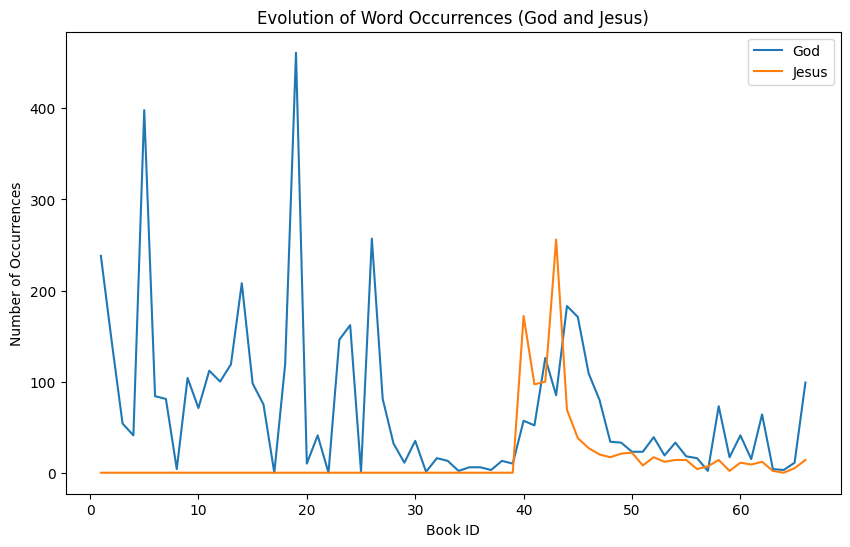

In [15]:
# Group the dataframe by book_id and calculate the sum of occurrences for each word
god_counts = bible_df.groupby('book_id')['cleaned'].apply(lambda x: x.explode().str.count('god').sum())
jesus_counts = bible_df.groupby('book_id')['cleaned'].apply(lambda x: x.explode().str.count('jesus').sum())

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(god_counts.index, god_counts.values, label='God')
plt.plot(jesus_counts.index, jesus_counts.values, label='Jesus')
plt.xlabel('Book ID')
plt.ylabel('Number of Occurrences')
plt.title('Evolution of Word Occurrences (God and Jesus)')
plt.legend()
plt.show()

In [16]:
# Filter the dataframe to include only books 1 to 37
old_testament_df = bible_df[(bible_df['book_id'] >= 1) & (bible_df['book_id'] <= 37)]

# Count the occurrences of the word "jesus" in the filtered dataframe
jesus_count = old_testament_df['text'].explode().str.count('jesus').sum()

# Print the result
print("Number of times 'Jesus' appears between books 1 and 37:", jesus_count)

Number of times 'Jesus' appears between books 1 and 37: 0


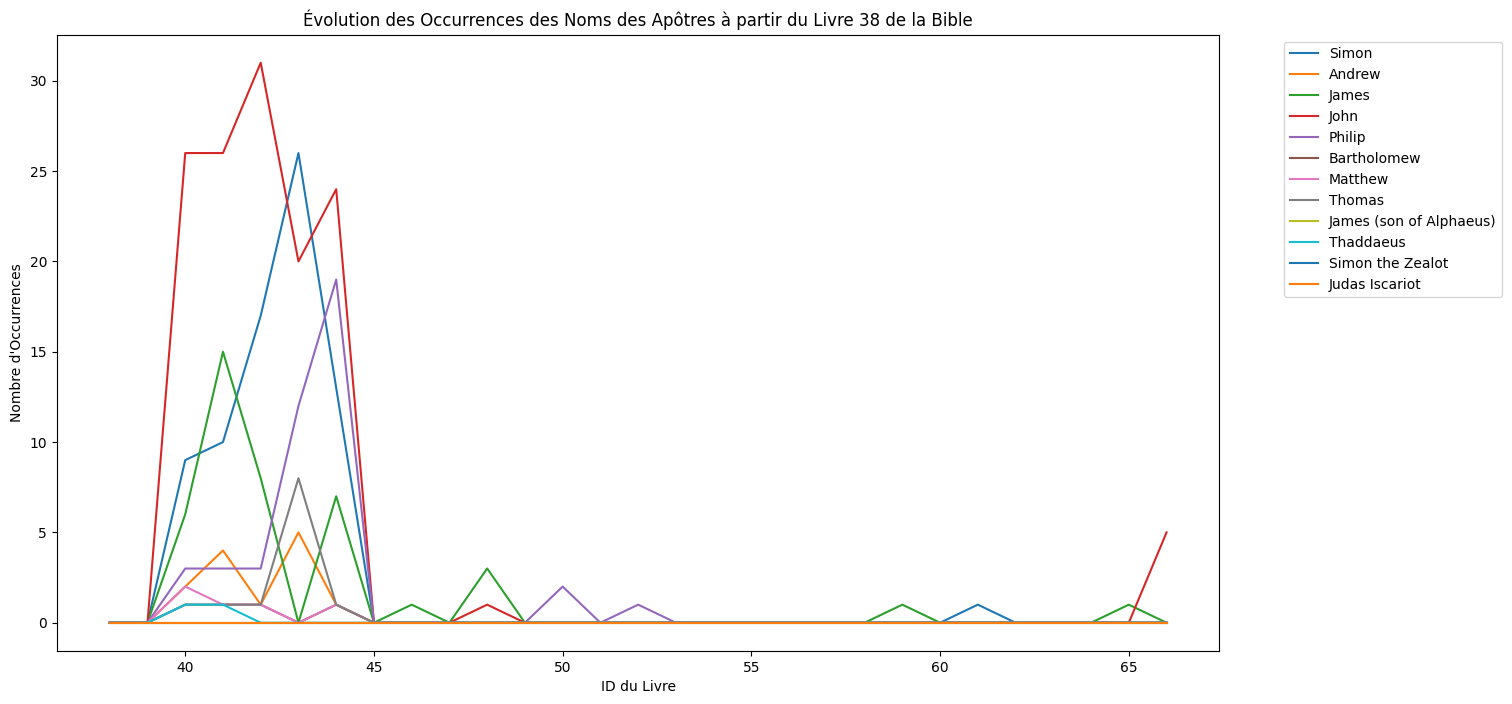

In [17]:
# Noms des apôtres
# TODO: to improve: use POS here?
apostles = ['Simon', 'Andrew', 'James', 'John', 'Philip', 'Bartholomew', 'Matthew', 'Thomas', 'James (son of Alphaeus)', 'Thaddaeus', 'Simon the Zealot', 'Judas Iscariot']

# Initialiser un dictionnaire pour stocker les occurrences des noms des apôtres par livre
apostle_counts = {apostle: [] for apostle in apostles}

# Parcourir les apôtres
for apostle in apostles:
    # Calculer les occurrences pour chaque apôtre à partir du livre 35
    counts = bible_df[bible_df['book_id'] >= 38].groupby('book_id')['cleaned'].apply(lambda x: x.explode().str.count(apostle.lower()).sum())
    apostle_counts[apostle] = counts.values

# Créer un graphique en ligne pour chaque apôtre
plt.figure(figsize=(15, 8))
for apostle in apostles:
    plt.plot(counts.index, apostle_counts[apostle], label=apostle)

plt.xlabel('ID du Livre')
plt.ylabel('Nombre d\'Occurrences')
plt.title('Évolution des Occurrences des Noms des Apôtres à partir du Livre 38 de la Bible')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## 4.Transformation des données
### POS Tagging

In [18]:
# Perform part-of-speech tagging on the "cleaned" column
bible_df['pos_tags'] = bible_df['cleaned'].apply(lambda x: nltk.pos_tag(x))

# Print only the "pos_tags" column
print(bible_df['pos_tags'])

0        [(beginning, VBG), (god, NN), (created, VBD), ...
1        [(earth, NN), (without, IN), (form, NN), (void...
2        [(god, NN), (said, VBD), (let, JJ), (light, JJ...
3        [(god, NN), (saw, VBD), (light, JJ), (good, JJ...
4        [(god, NN), (called, VBD), (light, JJ), (day, ...
                               ...                        
31098    [(spirit, NN), (bride, IN), (say, VBP), (come,...
31099    [(testify, VB), (unto, JJ), (every, DT), (man,...
31100    [(man, NN), (shall, MD), (take, VB), (away, RP...
31101    [(testifieth, JJ), (thing, NN), (saith, NN), (...
31102    [(grace, NN), (lord, NN), (jesus, NN), (christ...
Name: pos_tags, Length: 31103, dtype: object


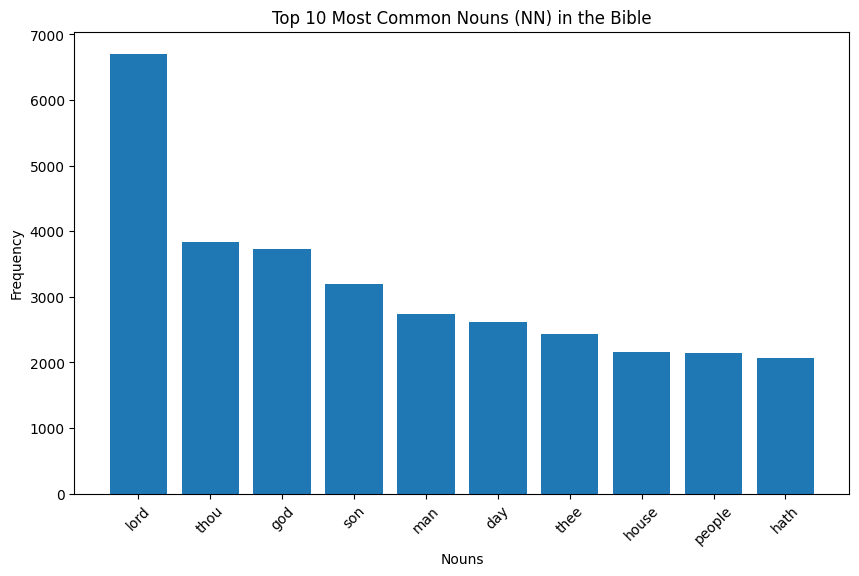

In [19]:
# Perform part-of-speech tagging on the "cleaned" column
bible_df['pos_tags'] = bible_df['cleaned'].apply(lambda x: nltk.pos_tag(x))

# Extract all the nouns from the "pos_tags" column
nouns = [word for tags in bible_df['pos_tags'] for word, pos in tags if pos.startswith('NN')]

# Count the frequency of each noun
noun_counts = Counter(nouns)

# Select the top 10 most frequent nouns
top_nouns = noun_counts.most_common(10)

# Extract the nouns and their frequencies
nouns, frequencies = zip(*top_nouns)

# Plot the frequency of the top 10 nouns
plt.figure(figsize=(10, 6))
plt.bar(nouns, frequencies)
plt.xlabel('Nouns')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Nouns (NN) in the Bible')
plt.xticks(rotation=45)
plt.show()


### NER 

In [20]:
# Tokenization and POS tagging
tokens = bible_df['cleaned']
pos_tags = bible_df['pos_tags']

print(tokens[0])
print(pos_tags[0])

['beginning', 'god', 'created', 'heaven', 'earth']
[('beginning', 'VBG'), ('god', 'NN'), ('created', 'VBD'), ('heaven', 'RB'), ('earth', 'JJ')]


In [21]:
# Perform Named Entity Recognition (NER)
ner_tags = [nltk.ne_chunk(tags) for tags in pos_tags]

# Print the NER tags
for tags in ner_tags:
    print(tags)

(S beginning/VBG god/NN created/VBD heaven/RB earth/JJ)
(S
  earth/NN
  without/IN
  form/NN
  void/NN
  darkness/NN
  upon/IN
  face/NN
  deep/JJ
  spirit/NN
  god/NN
  moved/VBD
  upon/JJ
  face/NN
  water/NN)
(S god/NN said/VBD let/JJ light/JJ light/NN)
(S
  god/NN
  saw/VBD
  light/JJ
  good/JJ
  god/NN
  divided/VBD
  light/JJ
  darkness/NN)
(S
  god/NN
  called/VBD
  light/JJ
  day/NN
  darkness/NN
  called/VBN
  night/NN
  evening/VBG
  morning/NN
  first/RB
  day/NN)
(S
  god/NN
  said/VBD
  let/JJ
  firmament/JJ
  midst/NN
  water/NN
  let/VB
  divide/JJ
  water/NN
  water/NN)
(S
  god/NN
  made/VBD
  firmament/NN
  divided/JJ
  water/NN
  firmament/JJ
  water/NN
  firmament/NN
  so/RB)
(S
  god/NN
  called/VBN
  firmament/JJ
  heaven/NN
  evening/VBG
  morning/NN
  second/JJ
  day/NN)
(S
  god/NN
  said/VBD
  let/JJ
  water/NN
  heaven/VB
  gathered/VBN
  together/RB
  unto/JJ
  one/CD
  place/NN
  let/NN
  dry/JJ
  land/NN
  appear/VBP
  so/RB)
(S
  god/NN
  called/VBN
  dry

### Bag of Words 

In [35]:
# get all uniques words and add them to a dataframe
bible_df['cleaned_string'] = bible_df['cleaned'].apply(lambda x: ' '.join(x))

# get bag of words features in sparse format
cv = CountVectorizer()
cv_matrix = cv.fit_transform(bible_df['cleaned_string'])

cv_matrix_array = cv_matrix.toarray()
cv_matrix_array

# get all unique words in the corpus
vocab = cv.get_feature_names_out()

# show document feature vectors
bible_df_feature_vectors = pd.DataFrame(cv_matrix_array, columns=vocab)

bible_df_feature_vectors

aaron  aaronites  abaddon  abagtha  abana  abarim  abase  abased  \
0          0          0        0        0      0       0      0       0   
1          0          0        0        0      0       0      0       0   
2          0          0        0        0      0       0      0       0   
3          0          0        0        0      0       0      0       0   
4          0          0        0        0      0       0      0       0   
...      ...        ...      ...      ...    ...     ...    ...     ...   
31098      0          0        0        0      0       0      0       0   
31099      0          0        0        0      0       0      0       0   
31100      0          0        0        0      0       0      0       0   
31101      0          0        0        0      0       0      0       0   
31102      0          0        0        0      0       0      0       0   

       abasing  abated  ...  zorathites  zoreah  zorites  zorobabel  zuar  \
0            0       0  ...           0       0        0          0     0   
1            0       0  ...           0       0        0          0     0   
2            0       0  ...           0       0        0          0     0   
3            0       0  ...           0       0        0          0     0   
4            0       0  ...           0       0        0          0     0   
...        ...     ...  ...         ...     ...      ...        ...   ...   
31098        0       0  ...           0       0        0          0     0   
31099        0       0  ...           0       0        0          0     0   
31100        0       0  ...           0       0        0          0     0   
31101        0       0  ...           0       0        0          0     0   
31102        0       0  ...           0       0        0          0     0   

       zuph  zur  zuriel  zurishaddai  zuzims  
0         0    0       0            0       0  
1         0    0       0            0       0  
2         0    0       0            0       0  
3         0    0       0            0       0  
4         0    0       0            0       0  
...     ...  ...     ...          ...     ...  
31098     0    0       0            0       0  
31099     0    0       0            0       0  
31100     0    0       0            0       0  
31101     0    0       0            0       0  
31102     0    0       0            0       0  

[31103 rows x 11386 columns]

### N-Gram Model

Récupération des bi-grammes les plus intéressants, avec une occurence tous textes confondus supérieure à 50

In [148]:
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(bible_df['cleaned_string'])
bv_matrix_array = bv_matrix.toarray()
vocab = bv.get_feature_names_out()
bible_df_bigram_trigram = pd.DataFrame(bv_matrix_array, columns=vocab)
bible_df_bigram_trigram = bible_df_bigram_trigram.astype('int8')

big_features_sum = bible_df_bigram_trigram.sum()

# Get features with more than 50 repetitions in the whole dataset
big_features_sum_selected = big_features_sum[big_features_sum >= 50]

# Select features to be removed
to_be_kept = list(set(vocab)-(set(vocab) - set(big_features_sum_selected.index)))

# Clean bigram df
bible_df_bigram_trigram_cleaned =  pd.DataFrame(bible_df_bigram_trigram, columns=to_be_kept)
sum_bigrams = (bible_df_bigram_trigram_cleaned.sum()).sort_values(ascending=False)

# Top ten bigrams
# TODO: make a barplot ? 
print(sum_bigrams[0:10])
del bible_df_bigram_trigram

said unto       1696
thou shalt      1250
lord god         958
unto him         890
saith lord       858
unto them        778
thou hast        772
ye shall         762
child israel     648
unto lord        549
dtype: int64


### TF-IDF

In [196]:
books = {}
for verse in range(len(bible_df)):
    current_book = bible_df['book_id'].iloc[verse]
    if(current_book in books):
        books[current_book] = list(books[current_book]) + list(bible_df['cleaned'].iloc[verse])
    else: 
        books[current_book] = list(bible_df['cleaned'].iloc[verse])

for key, value in books.items(): 
    books[key] = ' '.join(value)

books_list = list(books.values())
books_df = pd.DataFrame(books_list, columns=['corpus'])

del books_list

In [197]:
tfidf_vectorizer = TfidfVectorizer()

# Fit the TfidfVectorizer on the joined text
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['corpus'])

# Get the feature names (vocabulary)
vocab = tfidf_vectorizer.get_feature_names_out()

# Create a list to store the top 3 TF-IDF terms for each book
top_tfidf_terms_list = []

# Iterate over each book and get the top 3 TF-IDF terms
for idx, book in enumerate(books_df['corpus']):
    tfidf_scores = tfidf_matrix[idx, :].toarray().flatten()
    
    # Create a dictionary to store the term and its TF-IDF score
    tfidf_dict = {term: round(score, 1) for term, score in zip(vocab, tfidf_scores)}
    
    # Sort the terms by TF-IDF score and get the top 3 terms
    sorted_tfidf_terms = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:3] #
    
    # Append the results to the list
    top_tfidf_terms_list.append({'Book': idx, 'Top 3 Terms': sorted_tfidf_terms})

# Create a DataFrame from the list
top_tfidf_terms_df = pd.DataFrame(top_tfidf_terms_list)

# Display the DataFrame
print(top_tfidf_terms_df)

# pour arrondir les valeurs de la colonne 'Top 3 Terms' on utilise la fonction round

    Book                                    Top 3 Terms
0      0       [(said, 0.3), (unto, 0.3), (jacob, 0.2)]
1      1      [(lord, 0.3), (moses, 0.3), (shall, 0.3)]
2      2   [(shall, 0.6), (offering, 0.3), (lord, 0.2)]
3      3   [(shall, 0.4), (lord, 0.3), (offering, 0.3)]
4      4         [(thou, 0.4), (thy, 0.4), (lord, 0.3)]
..   ...                                            ...
61    61         [(god, 0.4), (love, 0.3), (hath, 0.2)]
62    62   [(christ, 0.3), (lady, 0.3), (abideth, 0.2)]
63    63  [(truth, 0.3), (beloved, 0.2), (church, 0.2)]
64    64  [(ungodly, 0.4), (christ, 0.2), (jesus, 0.2)]
65    65     [(angel, 0.2), (beast, 0.2), (earth, 0.2)]

[66 rows x 2 columns]


# Clustering

In [202]:
# Initialize a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=1000, stop_words='english')

# Fit and transform the Bible text to create embeddings
tfidf_matrix = tfidf_vectorizer.fit_transform(bible_df['cleaned'].apply(lambda x: " ".join(x)))

In [203]:
# Initialize PCA and reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(tfidf_matrix.toarray())
 
reduced_tfidf.shape

(31103, 2)

/Users/nathanst/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nathanst/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nathanst/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nathanst/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

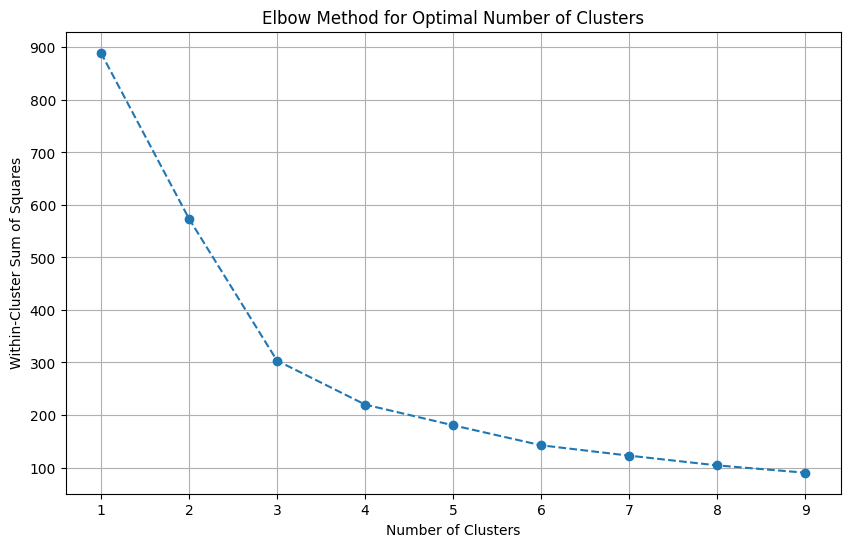

In [204]:
# Test d'Elbow pour déterminer le nombre optimal de clusters

 
# Determine the optimal number of clusters using the Elbow method
scores = []  # within-cluster sum of squares
cluster_range = range(1, 10)  # test up to 10 clusters
 
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(reduced_tfidf)
    scores.append(kmeans.inertia_)
 
#Plot the Elbow method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

/Users/nathanst/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


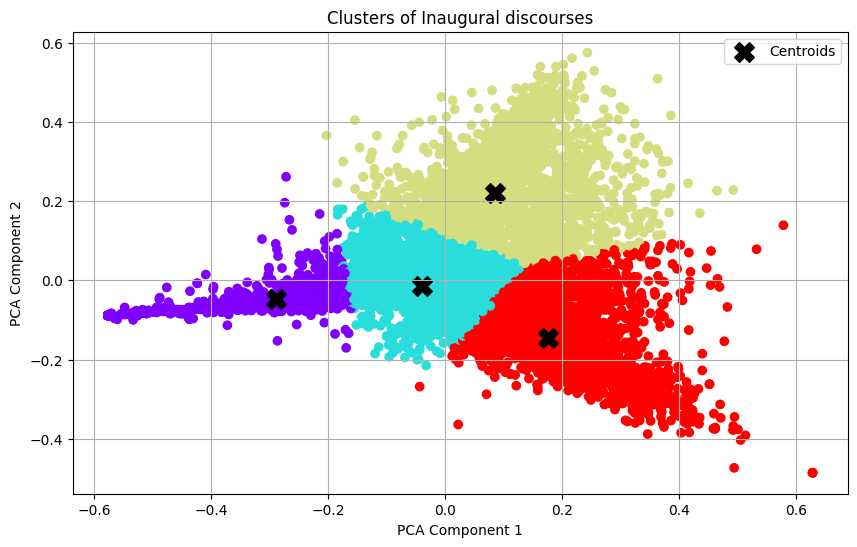

In [205]:
# Perform KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=100)
clusters = kmeans.fit_predict(reduced_tfidf)
 
# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=clusters, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='black', marker='X', label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Bible Topics')
plt.legend()
plt.grid(True)
plt.show()

In [207]:
X_train = bible_df['text']
y_km = kmeans.fit_predict(reduced_tfidf)
df_km = pd.DataFrame({'statements' :X_train, 'topic_cluster' :y_km })
print(df_km.groupby('topic_cluster').count())
df_km.head(10)

               statements
topic_cluster            
0                    1424
1                   20264
2                    4701
3                    4714


/Users/nathanst/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


statements  topic_cluster
0  In the beginning God created the heaven and th...              1
1  And the earth was without form, and void; and ...              1
2  And God said, Let there be light: and there wa...              1
3  And God saw the light, that it was good: and G...              1
4  And God called the light Day, and the darkness...              1
5  And God said, Let there be a firmament in the ...              1
6  And God made the firmament, and divided the wa...              1
7  And God called the firmament Heaven. And the e...              1
8  And God said, Let the waters under the heaven ...              1
9  And God called the dry land Earth; and the gat...              1

# LDA

In [208]:
# Assuming 'text' column contains tokenized words for each document
tokenized_texts = bible_df['cleaned'].tolist()

# Create the dictionary
id2word = corpora.Dictionary(tokenized_texts)

# Create the corpus
corpus = [id2word.doc2bow(text) for text in tokenized_texts]


In [209]:
# number of topics
num_topics = 4
# Build LDA model
lda_model3 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                        random_state=100)
# Print the Keyword in the 3 topics
pprint(lda_model3.print_topics(num_topics))
doc_lda3 = 0

[(0,
  '0.035*"unto" + 0.015*"son" + 0.013*"god" + 0.012*"shall" + 0.011*"lord" + '
  '0.010*"said" + 0.010*"you" + 0.009*"ye" + 0.008*"come" + 0.008*"him"'),
 (1,
  '0.022*"shall" + 0.020*"lord" + 0.018*"king" + 0.013*"unto" + 0.010*"hath" + '
  '0.009*"upon" + 0.009*"man" + 0.009*"said" + 0.009*"him" + 0.008*"them"'),
 (2,
  '0.023*"lord" + 0.023*"unto" + 0.022*"shall" + 0.019*"god" + 0.019*"ye" + '
  '0.015*"thee" + 0.012*"thou" + 0.012*"thy" + 0.010*"said" + 0.009*"him"'),
 (3,
  '0.028*"thou" + 0.027*"shall" + 0.020*"unto" + 0.017*"lord" + 0.015*"thy" + '
  '0.013*"god" + 0.012*"son" + 0.010*"man" + 0.009*"upon" + 0.008*"shalt"')]


In [210]:
# Assuming 'text' column contains lists of tokenized words for each document
tokenized_texts = bible_df['cleaned'].tolist()

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model3, texts=tokenized_texts, dictionary=id2word, coherence='u_mass')
coherence_score = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_score)


Coherence Score:  -2.55229680109339


In [ ]:
# Visualisation of topics 
vis_data = gensimvis.prepare(lda_model3, corpus, id2word, sort_topics=False)
pyLDAvis.save_html(vis_data, 'output_topics_LDA.html')
pyLDAvis.display(vis_data)

In [ ]:
# Choosing number of topics Round 2
topics = list(range(1, 20))
coherences = []

for no_topics in topics:
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=no_topics, random_state=100)
    
   
    tokenized_texts = bible_df_cleaned['cleaned'].tolist()
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=id2word, coherence='u_mass')
    coherences.append(coherence_model_lda.get_coherence())
    print(coherence_model_lda.get_coherence())

doc_lda = lda_model[corpus]


-2.3956986649651153


KeyboardInterrupt: 

# 3.Sentiment Analysis avec NLTK (from nltk.sentiment import sentimentIntensityAnalyzer)

In [ ]:
bible_df_cleaned

id  book_id  chapter_id  verse_id  \
0       1001001        1           1         1   
1       1001002        1           1         2   
2       1001003        1           1         3   
3       1001004        1           1         4   
4       1001005        1           1         5   
...         ...      ...         ...       ...   
31098  66022017       66          22        17   
31099  66022018       66          22        18   
31100  66022019       66          22        19   
31101  66022020       66          22        20   
31102  66022021       66          22        21   

                                                    text  \
0      In the beginning God created the heaven and th...   
1      And the earth was without form, and void; and ...   
2      And God said, Let there be light: and there wa...   
3      And God saw the light, that it was good: and G...   
4      And God called the light Day, and the darkness...   
...                                                  ...   
31098  And the Spirit and the bride say, Come. And le...   
31099  For I testify unto every man that heareth the ...   
31100  And if any man shall take away from the words ...   
31101  He which testifieth these things saith, Surely...   
31102  The grace of our Lord Jesus Christ be with you...   

                                                 cleaned  word_count  \
0               [beginning, god, created, heaven, earth]           5   
1      [earth, without, form, void, darkness, upon, f...          14   
2                         [god, said, let, light, light]           5   
3      [god, saw, light, good, god, divided, light, d...           8   
4      [god, called, light, day, darkness, called, ni...          11   
...                                                  ...         ...   
31098  [spirit, bride, say, come, let, heareth, say, ...          18   
31099  [testify, unto, every, man, heareth, word, pro...          20   
31100  [man, shall, take, away, word, book, prophecy,...          19   
31101  [testifieth, thing, saith, surely, come, quick...          12   
31102            [grace, lord, jesus, christ, all, amen]           6   

       unique_words  avg_word_length  sentence_count  \
0                 5         6.000000               1   
1                12         4.785714               2   
2                 4         4.000000               1   
3                 6         4.750000               1   
4                 9         5.272727               2   
...             ...              ...             ...   
31098            13         4.666667               4   
31099            14         4.700000               0   
31100            14         4.421053               1   
31101            11         5.000000               3   
31102             6         4.500000               2   

                                                pos_tags  \
0      [(beginning, VBG), (god, NN), (created, VBD), ...   
1      [(earth, NN), (without, IN), (form, NN), (void...   
2      [(god, NN), (said, VBD), (let, JJ), (light, JJ...   
3      [(god, NN), (saw, VBD), (light, JJ), (good, JJ...   
4      [(god, NN), (called, VBD), (light, JJ), (day, ...   
...                                                  ...   
31098  [(spirit, NN), (bride, IN), (say, VBP), (come,...   
31099  [(testify, VB), (unto, JJ), (every, DT), (man,...   
31100  [(man, NN), (shall, MD), (take, VB), (away, RP...   
31101  [(testifieth, JJ), (thing, NN), (saith, NN), (...   
31102  [(grace, NN), (lord, NN), (jesus, NN), (christ...   

                                            cleaned_text  cluster_label  
0                     beginning god created heaven earth              0  
1      earth without form void darkness upon face dee...              0  
2                               god said let light light              0  
3          god saw light good god divided light darkness              0  
4      god called light day darkness called night eve...      

In [ ]:
# Download NLTK resources
nltk.download('vader_lexicon')

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Convert the list of words to a string
bible_df_cleaned['cleaned_text'] = bible_df_cleaned['cleaned'].apply(lambda x: ' '.join(x))




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Define a function to calculate sentiment score for a given verse
def get_sentiment_score(verse):
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(verse)['compound']
    return sentiment_score

# Apply the sentiment analysis function to the 'cleaned_text' column in your DataFrame
bible_df_cleaned['sentiment_score'] = bible_df_cleaned['cleaned_text'].apply(get_sentiment_score)

# Categorize sentiment based on the sentiment score
bible_df_cleaned['sentiment'] = bible_df_cleaned['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')

# Display the DataFrame with sentiment scores and categories
print(bible_df_cleaned[['text', 'sentiment_score', 'sentiment']])


                                                    text  sentiment_score  \
0      In the beginning God created the heaven and th...           0.7506   
1      And the earth was without form, and void; and ...           0.5484   
2      And God said, Let there be light: and there wa...           0.2732   
3      And God saw the light, that it was good: and G...           0.6249   
4      And God called the light Day, and the darkness...           0.0258   
...                                                  ...              ...   
31098  And the Spirit and the bride say, Come. And le...           0.5574   
31099  For I testify unto every man that heareth the ...           0.2732   
31100  And if any man shall take away from the words ...           0.2732   
31101  He which testifieth these things saith, Surely...           0.4404   
31102  The grace of our Lord Jesus Christ be with you...           0.4215   

      sentiment  
0      positive  
1      positive  
2      positive  
3  

In [ ]:
# Create a new DataFrame for visualization

visualization_df = pd.DataFrame({
    'Verse': bible_df_cleaned['text'],
    'Sentiment Score': bible_df_cleaned['sentiment_score'],
    'Sentiment': bible_df_cleaned['sentiment']
})

visualization_df


Verse  Sentiment Score  \
0      In the beginning God created the heaven and th...           0.7506   
1      And the earth was without form, and void; and ...           0.5484   
2      And God said, Let there be light: and there wa...           0.2732   
3      And God saw the light, that it was good: and G...           0.6249   
4      And God called the light Day, and the darkness...           0.0258   
...                                                  ...              ...   
31098  And the Spirit and the bride say, Come. And le...           0.5574   
31099  For I testify unto every man that heareth the ...           0.2732   
31100  And if any man shall take away from the words ...           0.2732   
31101  He which testifieth these things saith, Surely...           0.4404   
31102  The grace of our Lord Jesus Christ be with you...           0.4215   

      Sentiment  
0      positive  
1      positive  
2      positive  
3      positive  
4      positive  
...         ...  
31098  positive  
31099  positive  
31100  positive  
31101  positive  
31102  positive  

[31103 rows x 3 columns]

In [ ]:
negative_verses = visualization_df[visualization_df['Sentiment'] == 'negative']
negative_verses

# exemple words negative : evil, wicked, hate, kill, death, sin, devil, hell, etc.

Verse  Sentiment Score  \
47     But of the tree of the knowledge of good and e...          -0.5423   
54     Therefore shall a man leave his father and his...          -0.0516   
55     And they were both naked, the man and his wife...          -0.4767   
58     But of the fruit of the tree which is in the m...          -0.4215   
59     And the serpent said unto the woman, Ye shall ...          -0.2500   
...                                                  ...              ...   
31054  And whosoever was not found written in the boo...          -0.3400   
31062  But the fearful, and unbelieving, and the abom...          -0.9712   
31084  And there shall be no more curse: but the thro...          -0.3400   
31092  He that is unjust, let him be unjust still: an...          -0.7650   
31096  For without are dogs, and sorcerers, and whore...          -0.3971   

      Sentiment  
47     negative  
54     negative  
55     negative  
58     negative  
59     negative  
...         ...  
31054  negative  
31062  negative  
31084  negative  
31092  negative  
31096  negative  

[8204 rows x 3 columns]

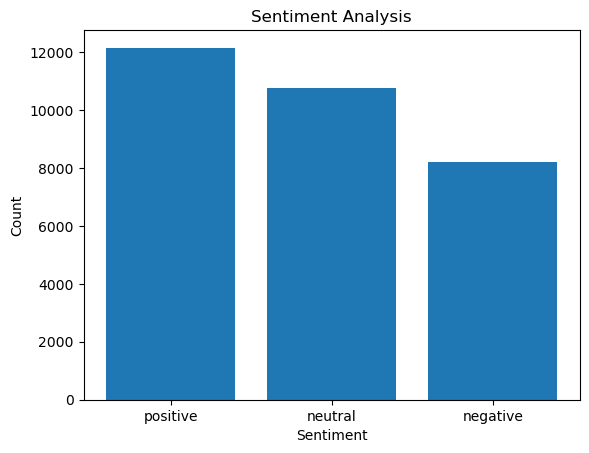

In [ ]:
# Calculate the count of each sentiment category
sentiment_counts = visualization_df['Sentiment'].value_counts()

# Plot the sentiment counts
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Analysis')
plt.show()


In [ ]:
visualization_df['book_id'] = bible_df_cleaned['book_id']
visualization_df

Verse  Sentiment Score  \
0      In the beginning God created the heaven and th...           0.7506   
1      And the earth was without form, and void; and ...           0.5484   
2      And God said, Let there be light: and there wa...           0.2732   
3      And God saw the light, that it was good: and G...           0.6249   
4      And God called the light Day, and the darkness...           0.0258   
...                                                  ...              ...   
31098  And the Spirit and the bride say, Come. And le...           0.5574   
31099  For I testify unto every man that heareth the ...           0.2732   
31100  And if any man shall take away from the words ...           0.2732   
31101  He which testifieth these things saith, Surely...           0.4404   
31102  The grace of our Lord Jesus Christ be with you...           0.4215   

      Sentiment  book_id  
0      positive        1  
1      positive        1  
2      positive        1  
3      positive        1  
4      positive        1  
...         ...      ...  
31098  positive       66  
31099  positive       66  
31100  positive       66  
31101  positive       66  
31102  positive       66  

[31103 rows x 4 columns]

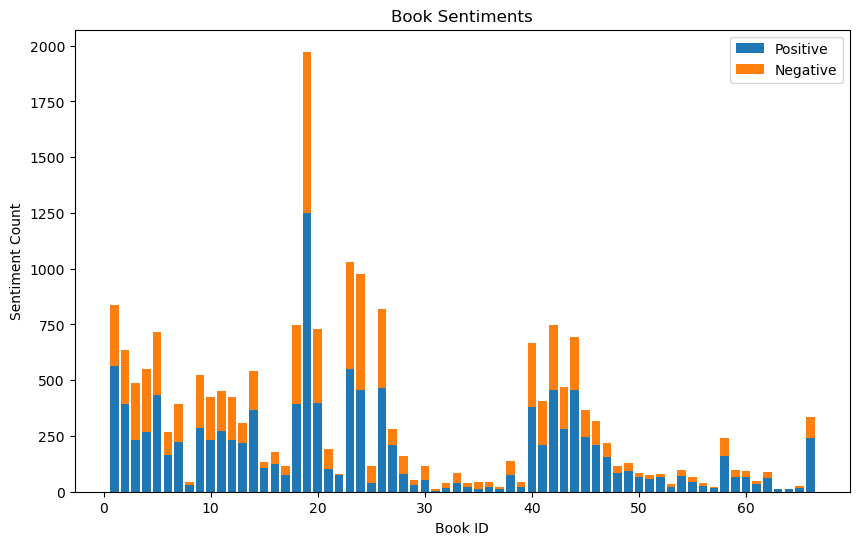

In [ ]:



# Calculate the count of positive and negative sentiments for each book_id
sentiment_counts = visualization_df.groupby('book_id')['Sentiment'].value_counts().unstack().fillna(0)

# Determine if each book_id is positive or negative based on sentiment counts
sentiment_counts['Book Sentiment'] = sentiment_counts.apply(lambda row: 'positive' if row['positive'] > row['negative'] else 'negative', axis=1)

# Plot the book sentiments
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts['positive'], label='Positive')
plt.bar(sentiment_counts.index, sentiment_counts['negative'], bottom=sentiment_counts['positive'], label='Negative')
plt.xlabel('Book ID')
plt.ylabel('Sentiment Count')
plt.title('Book Sentiments')
plt.legend()
plt.show()


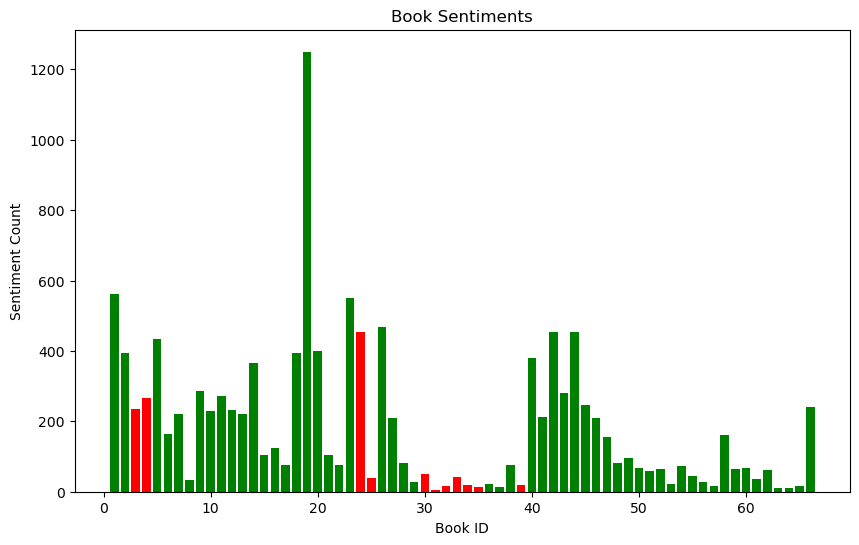

In [ ]:
# Permet de voir les sentiments par livre de la bible (positif ou négatif)
# si plus de verse positif que négatif alors le livre est positif (et inversement)


# Calculate the count of positive and negative sentiments for each book_id
sentiment_counts = visualization_df.groupby('book_id')['Sentiment'].value_counts().unstack().fillna(0)

# Determine if each book_id is positive or negative based on sentiment counts
sentiment_counts['Book Sentiment'] = sentiment_counts.apply(lambda row: 'positive' if row['positive'] > row['negative'] else 'negative', axis=1)

# Assign colors based on sentiment
colors = ['green' if sentiment == 'positive' else 'red' for sentiment in sentiment_counts['Book Sentiment']]

# Plot the book sentiments with assigned colors
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts['positive'], color=colors)
plt.xlabel('Book ID')
plt.ylabel('Sentiment Count')
plt.title('Book Sentiments')
plt.show()
